In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
Dataset_path="Downloads/exam"
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42

In [7]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="training",
    batch_size=BATCH_SIZE,
    seed=SEED,
    image_size=IMG_SIZE,
    shuffle=True)
full_valid_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=SEED,
    image_size=IMG_SIZE)

train_size=len(train_ds)
val_size=len(full_valid_ds)//2
test_size=len(full_valid_ds)-val_size

valid_ds=full_valid_ds.take(val_size)
test_ds=full_valid_ds.skip(val_size)




Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [10]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3),padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [11]:
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=2)

Epoch 1/2
22/22 [==============================] - 74s 3s/step - loss: 2.2308 - accuracy: 0.5171 - val_loss: 0.8110 - val_accuracy: 0.4875
Epoch 2/2
22/22 [==============================] - 68s 3s/step - loss: 0.6995 - accuracy: 0.4971 - val_loss: 0.6892 - val_accuracy: 0.5125


In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['cats_set', 'dogs_set']


In [13]:
for images, labels in valid_ds.take(1):
    image=images[0].numpy().astype(np.uint8)
    label=labels[0].numpy()
    break
    

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 299ms/step


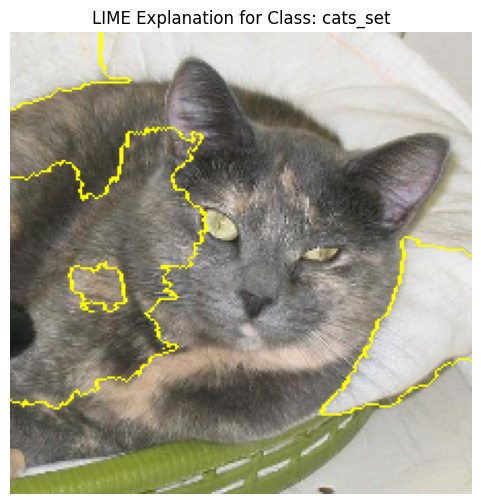

In [17]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
explainer=lime_image.LimeImageExplainer()
def predict_fn(images):
    images=np.array(images)
    images=tf.image.resize(images,IMG_SIZE)
    return model.predict(images)
explanation=explainer.explain_instance(image,
                                       predict_fn,
                                       top_labels=5,
                                       hide_color=0,
                                       num_samples=1000)

temp,mask=explanation.get_image_and_mask(explanation.top_labels[0],positive_only=True, num_features=5, hide_rest=False)
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class: {class_names[label]}")
plt.axis('off')
plt.show()